<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-a-z-con-python/blob/main/ES_TA_Cap%C3%ADtulo_05_Backtesting_Vectorizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# BackTesting Vectorizado

El backtesting es una parte esencial del trading. En efecto, es importante comprender el comportamiento de nuestra estrategia en el pasado para poder considerar los del futuro.

### Contenido

- Sortino Beta Alpha
- Drawdown
- Crear la función BackTest para evaluar la estrategia en las secciones posteriores

</br>

💰 Únete a la comunidad de [Discord](https://discord.gg/z3dx5XpkX4)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.es/Python-para-finanzas-trading-algor%C3%ADtmico-ebook/dp/B0BT4ZS9Q3/)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español


In [4]:
!pip install yfinance

     ---------------------------------------- 63.0/63.0 KB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 1.6 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 KB 3.2 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\001548661\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Entorno


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler(
    "color", ["#669FEE", "#66EE91", "#9988DD", "#EECC55", "#88BB44", "#FFBBBB"]
)
plt.rc("figure", facecolor="#313233")
plt.rc(
    "axes",
    facecolor="#313233",
    edgecolor="none",
    axisbelow=True,
    grid=True,
    prop_cycle=colors,
    labelcolor="gray",
)
plt.rc("grid", color="474A4A", linestyle="solid")
plt.rc("xtick", color="gray")
plt.rc("ytick", direction="out", color="gray")
plt.rc("legend", facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc("figure", facecolor="#313233")

# Sección 1: Sortino Beta Alpha


###### Sortino

El índice de Sortino es una estadística similar al índice de Sharpe con la misma interpretación. Sin embargo, el cálculo es ligeramente diferente. En efecto, en el índice de Sortino sólo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar dinero. <br>

<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

- SortinoRatio < 0 : Inversión no rentable porque las ganancias son negativas.
- SortinoRatio < 1: Inversión rentable, pero el riesgo de la inversión es mayor que la rentabilidad.
- SortinoRatio > 1: Inversión muy rentable porque el riesgo es menor que el rendimiento.


In [15]:
# Preparar los datos
f = yf.download("BTC-USD", end="2021-01-01")
# Tomamos la columna "adj close", porcentaje de ganancia a 1
return_serie = f["Adj Close"].pct_change(1).dropna()
# Cambiar el nombre a la serie
return_serie.name = "return"

# Calcular el indice de sortino
rentabilidad_media = np.mean(return_serie)  # 252
# Desviacion estandar
downside_risk = np.std(return_serie[return_serie < 0])  # np.sqrt(252)

sortino = np.sqrt(252) * rentabilidad_media / downside_risk

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.345


Date
2014-09-18   -0.071926
2014-09-19   -0.069843
2014-09-20    0.035735
2014-09-21   -0.024659
2014-09-22    0.008352
                ...   
2020-12-27   -0.006231
2020-12-28    0.030927
2020-12-29    0.010250
2020-12-30    0.054034
2020-12-31    0.005574
Name: return, Length: 2297, dtype: float64

###### Beta

La beta es un estadístico que indica la relación entre las variaciones de nuestra cartera y las del mercado que está representado por un índice (por ejemplo el SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>

- abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variación menor que el índice. (Si beta=0,9 significa que si el índice varía en 1 la cartera varía en 0,9)
- abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variación mayor que el índice. (Si beta=1,1 significa que si el índice varía de 1 la cartera varía en 1,1)

_abs(-x) = x = abs(x) (abs da sólo el valor de la variable no el signo)_


In [13]:
# Necesitamos calcular la covarianza entre el mercado y la cartera
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# Los concatenamos para hacer covarianzas
# Unimos las columnas "return_series" y "sp500" y eliminamos valore nulos
val = pd.concat((return_serie, sp500), axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


,return,SP500
Date,,
2014-09-18,-0.071926,0.004891
2014-09-19,-0.069843,-0.000477
2014-09-22,0.008352,-0.008013
2014-09-23,0.083647,-0.005777
2014-09-24,-0.028881,0.007832
...,...,...
2020-12-24,0.021281,0.003537
2020-12-28,0.030927,0.008723
2020-12-29,0.010250,-0.002227


In [14]:
# Calculamos la matriz de covarianzas
# rowvar=False -> No calcular por filas, solo columnas
cov_var_mat = np.cov(val.values, rowvar=False)

cov_var_mat

array([[1.68267689e-03, 6.55440584e-05],
       [6.55440584e-05, 1.35321013e-04]])

In [18]:
# Calculamos beta
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov / var

print(f"Beta: {'%.3f' % beta}")

Beta: 0.484


###### **Alpha**

El alfa es una estadístico que indica si la cartera supera al mercado en términos de rentabilidad del riesgo. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>

- alfa > 0: La cartera supera al mercado en términos de rentabilidad del riesgo
- alfa < 0: la cartera tiene un rendimiento inferior al del mercado en términos de riesgo-rendimiento


In [20]:
# Calcula Alpha
alpha = 252 * rentabilidad_media * (1 - beta)
print(f"Alpha: {'%.1f' % alpha} %")

Alpha: 0.3 %


# Sección 2: Drawdown

El drawdown (reducción) es una medida del riesgo de la estrategia. Una estadística interesante para conocer el rendimiento del algoritmo es el drawdown máximo. En efecto, representa la pérdida máxima de una estrategia durante un período de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en función de nuestro nivel de aversión al riesgo.


In [21]:
def drawdown_function(serie):
    # Calculamos la suma de los rendimientos
    # cumsum() -> Suma acumulada
    cum = serie.dropna().cumsum() + 1

    # Calculamos el maximo de la suma en el periodo (maximo acumulado)
    # maximum.accumulate(cum) -> Maximo acumulado
    running_max = np.maximum.accumulate(cum)

    # Calculamos el drawdown
    drawdown = cum / running_max - 1

    return drawdown

In [22]:
drawdown = drawdown_function(return_serie)
drawdown

Date
2014-09-18    0.000000
2014-09-19   -0.075255
2014-09-20   -0.036751
2014-09-21   -0.063321
2014-09-22   -0.054321
                ...   
2020-12-27   -0.000920
2020-12-28    0.000000
2020-12-29    0.000000
2020-12-30    0.000000
2020-12-31    0.000000
Name: return, Length: 2297, dtype: float64

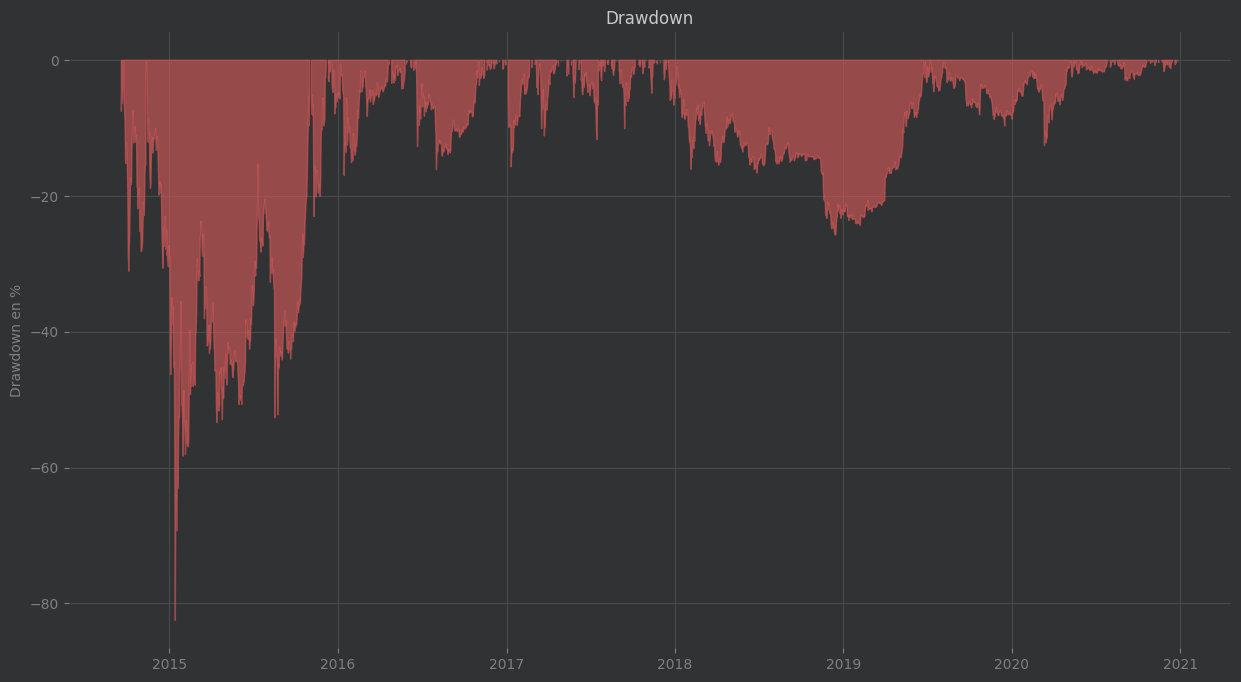

In [27]:
# Adaptar el tamaño de la figura
plt.figure(figsize=(15, 8))

# Representar el drawdown
plt.fill_between(
    drawdown.index, drawdown * 100, 0, drawdown, color="#CE5757", alpha=0.65
)

# Añadimos el titulo
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()

In [33]:
# Computation Max Drawdown
max_drawdown = -np.min(drawdown) * 100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 82.5 %


# Sección 3: Crear la función BackTest para evaluar la estrategia en las secciones posteriores


In [38]:
def BackTest(serie, annualiazed_scalar=252):
    # Importar el benchmark
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)

    # Cambiar el nombre
    sp500.name = "SP500"

    # Concatenar los retornos y el sp500
    val = pd.concat((serie, sp500), axis=1).dropna()
    # Calcular el drawdown
    drawdown = drawdown_function(serie) * 100

    # Calcular el max drawdown
    max_drawdown = -np.min(drawdown)

    # Grafico
    # Put a subplots
    fig, (cum, dra) = plt.subplots(1, 2, figsize=(20, 6))

    # Put a Suptitle
    fig.suptitle("Backtesting", size=20)

    # Returns cumsum chart
    cum.plot(serie.cumsum() * 100, color="#39B3C7")

    # SP500 cumsum chart
    cum.plot(val["SP500"].cumsum() * 100, color="#B85A0F")

    # Put a legend
    cum.legend(["Portfolio", "SP500"])

    # Set individual title
    cum.set_title("Cumulative Return", size=13)

    cum.set_ylabel("Cumulative Return %", size=11)

    # Put the drawdown
    dra.fill_between(drawdown.index, 0, drawdown, color="#C73954", alpha=0.65)

    # Set individual title
    dra.set_title("Drawdown", size=13)

    dra.set_ylabel("drawdown en %", size=11)

    # Plot the graph
    plt.show()

    # INDICES
    # Calcular el índice sortino
    sortino = np.sqrt(annualiazed_scalar) * serie.mean() / serie.loc[serie < 0].std()

    # Calcular el índice  beta
    beta = np.cov(val[["return", "SP500"]].values, rowvar=False)[0][1] / np.var(
        val["SP500"].values
    )

    # Calcular el índice  alpha
    alpha = annualiazed_scalar * (serie.mean() - beta * serie.mean())

    # Imprimir los estadísticos
    print(f"Sortino: {np.round(sortino,3)}")
    print(f"Beta: {np.round(beta,3)}")
    print(f"Alpha: {np.round(alpha*100,3)} %")
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


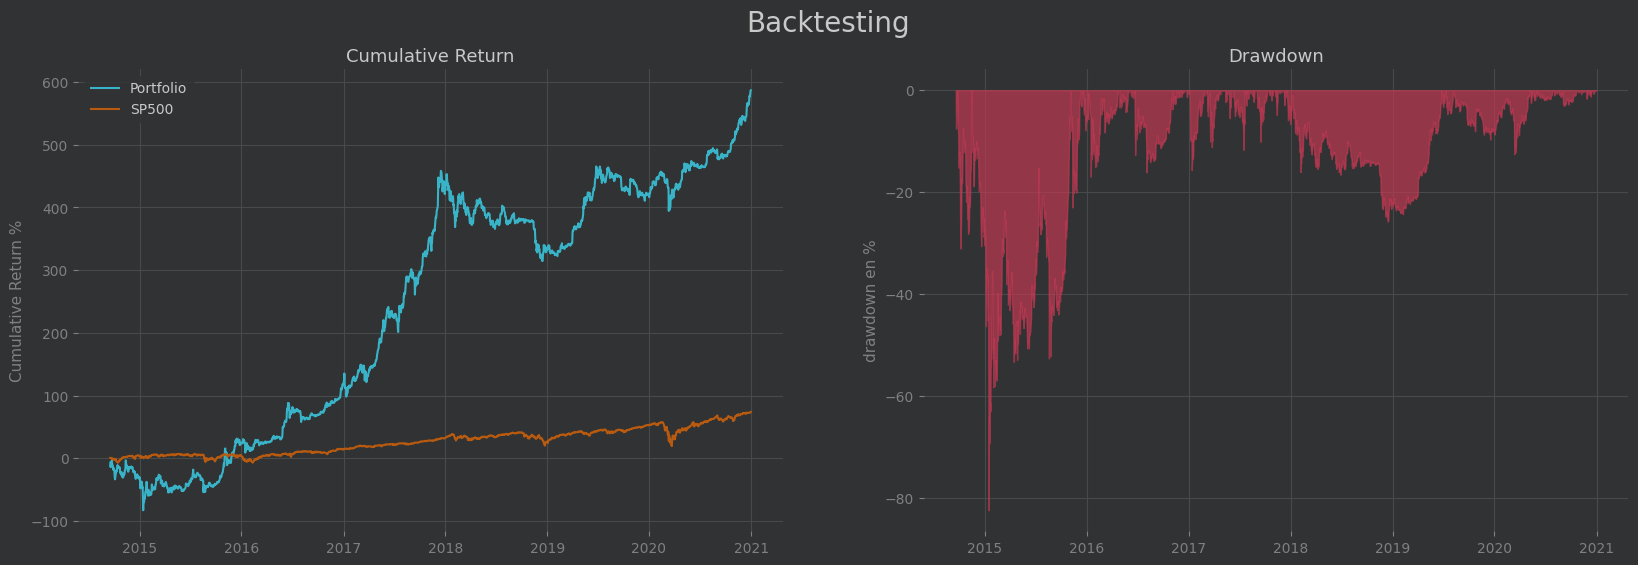

Sortino: 1.344
Beta: 0.485
Alpha: 33.187 %
MaxDrawdown: 82.508 %


In [40]:
BackTest(return_serie, annualiazed_scalar=252)

##### APLICACIÓN


In [39]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for ta, since package 'wheel' is not installed.
  Running setup.py install for ta: started
  Running setup.py install for ta: finished with status 'done'


You should consider upgrading via the 'C:\Users\001548661\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [41]:
def SMA_strategy(input, mt5=False, yf=False):
    if mt5:
        df = preprocessing(input)

    if yf:
        df = preprocessing_yf(input)

    # Create Resistance using a rolling max
    df["SMA fast"] = df["close"].rolling(30).mean()

    # Create Support using a rolling min
    df["SMA slow"] = df["close"].rolling(60).mean()

    df["position"] = np.nan

    # Create the condition
    df.loc[(df["SMA fast"] > df["SMA slow"]), "position"] = 1
    df.loc[(df["SMA fast"] < df["SMA slow"]), "position"] = -1

    df["pct"] = df["close"].pct_change(1)

    # Compute the return of the strategy

    df["return"] = df["pct"] * (df["position"].shift(1))

    return df["return"]


def preprocessing_yf(symbol):
    # Import the data
    df = yf.download("EURUSD=X").dropna()

    # Rename
    df.columns = ["open", "high", "low", "close", "adj close", "volume"]
    df.index.name = "time"

    # Remove adj close
    del df["adj close"]

    return df


def preprocessing(name):
    # Import the data
    df = pd.read_csv(name, delimiter="\t", index_col="<DATE>", parse_dates=True)

    # Delete the two last columns
    df = df.iloc[:, :-2]

    # Rename
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "time"

    return df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


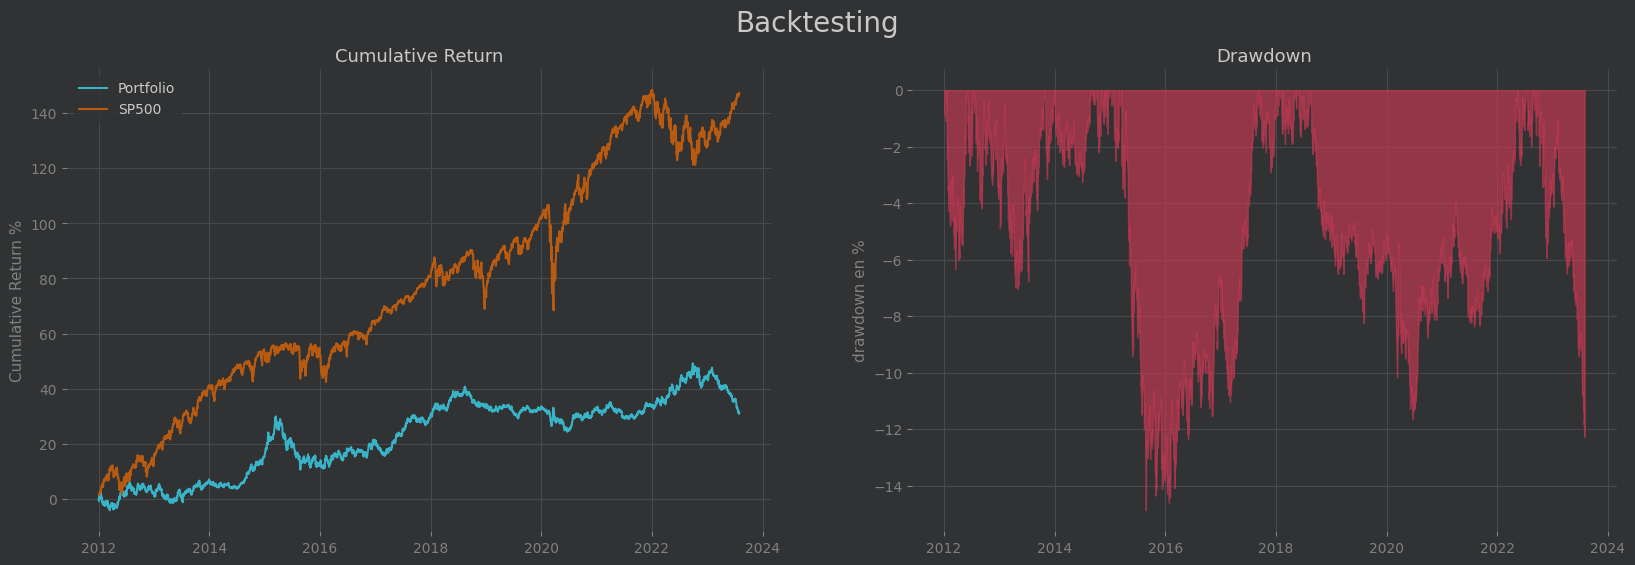

Sortino: 0.5
Beta: -0.0
Alpha: 2.599 %
MaxDrawdown: 14.876 %


In [45]:
# YAHOO
dfc = SMA_strategy("EURUSD=X", yf=True).loc["2012":] - 0.000001

BackTest(dfc, 252)

[*********************100%***********************]  1 of 1 completed


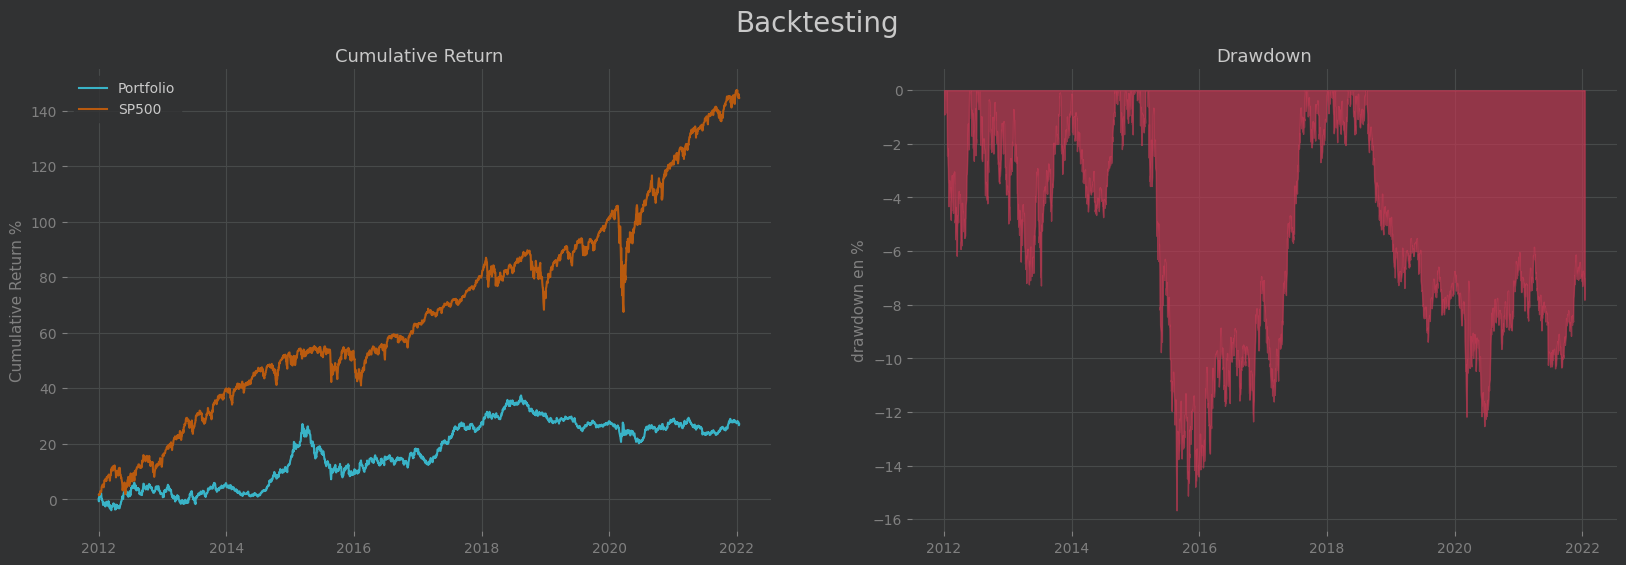

Sortino: 0.532
Beta: 0.011
Alpha: 2.58 %
MaxDrawdown: 15.668 %


In [47]:
# MT5
dfc = SMA_strategy("./FOREX D1/EURUSD_D1.csv", mt5=True).loc["2012":] - 0.00001

BackTest(dfc.fillna(value=0), 252)